### Did you just assumed my gender?

You are provided with a dataset with twitter profiles containing the user’s gender, description, favorite number, and number of tweets. You are called to create a machine learning algorithm that can predict the user’s gender based on the user’s description only. The gender can be male, female, or brand. Take a close inspection of the dataset and take care of any missing or irrelevant values. Split the dataset into training and test sets and try multiple classification algorithms. Optimize them and find the best possible classifier. Afterwards, for the favorite number, and number of tweets in your feature space, plot histograms based on the gender and perform statistical tests to check if there is a significant statistical difference. Include these features to your previous classification models. Do you see any improvement?

In [537]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from scipy import stats
from sklearn.naive_bayes import MultinomialNB 
## Only filter out warnings before running nbconvert
warnings.filterwarnings('ignore')

In [7]:
# first change delimiter from ';' to '\t'
# silly MACs https://unix.stackexchange.com/questions/141420/tr-complains-of-illegal-byte-sequence
!export LC_CTYPE=C && cat "/Users/brian/ALLODD PhD position assignments/tweeter_genders.csv" | tr ';' '\t' > "/Users/brian/ALLODD PhD position assignments/tweeter_genders.tsv"

In [440]:
# I think this file came from a Windows machine :( https://stackoverflow.com/questions/18171739/unicodedecodeerror-when-reading-csv-file-in-pandas-with-python
twitter_df = pd.read_csv("/Users/brian/ALLODD PhD position assignments/tweeter_genders.tsv", sep = '\t',
                         encoding='iso-8859-1')
twitter_df.head()

,gender,description,fav_number,tweet_count
0,male,i sing my own rhythm.,0,110964
1,male,I'm the author of novels filled with family dr...,68,7471
2,male,louis whining and squealing and all,7696,5617
3,male,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202,1693
4,female,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,37318,31462


In [ ]:
# Need to confirm setting variables works with panda's SettingWithCopyWarning: use loc and mask instead

In [441]:
# np.nan across columns and filter
print(twitter_df.isna().sum())
print()
print(twitter_df.dtypes)
# remove where gender not in male, female, or brand
twitter_df = twitter_df[twitter_df.gender.isin(['male', 'female', 'brand'])]

# input blank string "" is description is blank
mask = twitter_df.description.isna()
twitter_df.loc[mask, 'description'] = ""

gender         4404
description    8955
fav_number     5655
tweet_count    7793
dtype: int64

gender         object
description    object
fav_number     object
tweet_count    object
dtype: object


Setting favorite number and tweet counts to mean for each group

In [18]:
from collections import Counter

# what are top 3 favorite numbers from each group
print(Counter(twitter_df.fav_number[(~twitter_df.fav_number.isna()) & (twitter_df.gender=='male')]).most_common()[0:3])
print(Counter(twitter_df.fav_number[(~twitter_df.fav_number.isna()) & (twitter_df.gender=='female')]).most_common()[0:3])
print(Counter(twitter_df.fav_number[(~twitter_df.fav_number.isna()) & (twitter_df.gender=='brand')]).most_common()[0:3])
# impute fav number and tweet count with mean from each gender group
# doing this since the top 3 favorite numbers from each group were the same [0,1,2]

# since they are strings and not ints
male_mean = int(np.mean(twitter_df.fav_number[(~twitter_df.fav_number.isna()) & 
                                        (twitter_df.gender=='male')].astype(np.int32)))
male_mask = (twitter_df.fav_number.isna()) & (twitter_df.gender=='male')
twitter_df.loc[male_mask, 'fav_number'] = male_mean

female_mean = int(np.mean(twitter_df.fav_number[(~twitter_df.fav_number.isna()) & 
                                        (twitter_df.gender=='female')].astype(np.int32)))
female_mask = (twitter_df.fav_number.isna()) & (twitter_df.gender=='female')
twitter_df.loc[female_mask, 'fav_number'] = female_mean

brand_mean = int(np.mean(twitter_df.fav_number[(~twitter_df.fav_number.isna()) & 
                                        (twitter_df.gender=='brand')].astype(np.int32)))
brand_mask = (twitter_df.fav_number.isna()) & (twitter_df.gender=='brand')
twitter_df.loc[brand_mask, 'fav_number'] = brand_mean

# since they are strings and not ints
twitter_df.fav_number = twitter_df.fav_number.astype(np.int32)

[('0', 284), ('1', 85), ('2', 53)]
[('0', 416), ('1', 69), ('2', 51)]
[('0', 2224), ('1', 190), ('2', 124)]


In [20]:
# do same for tweet counts

# since they are strings and not ints
male_mean = int(np.mean(twitter_df.tweet_count[(~twitter_df.tweet_count.isna()) & 
                                        (twitter_df.gender=='male')].astype(np.int32)))
male_mask = (twitter_df.tweet_count.isna()) & (twitter_df.gender=='male')
twitter_df.loc[male_mask, 'tweet_count'] = male_mean

female_mean = int(np.mean(twitter_df.tweet_count[(~twitter_df.tweet_count.isna()) & 
                                        (twitter_df.gender=='female')].astype(np.int32)))
female_mask = (twitter_df.tweet_count.isna()) & (twitter_df.gender=='female')
twitter_df.loc[female_mask, 'tweet_count'] = female_mean

brand_mean = int(np.mean(twitter_df.fav_number[(~twitter_df.tweet_count.isna()) & 
                                        (twitter_df.gender=='brand')].astype(np.int32)))
brand_mask = (twitter_df.tweet_count.isna()) & (twitter_df.gender=='brand')
twitter_df.loc[brand_mask, 'tweet_count'] = brand_mean

# since they are strings and not ints
twitter_df.tweet_count = twitter_df.tweet_count.astype(np.int32)

print(twitter_df.isna().sum())
print(twitter_df.dtypes)
print(twitter_df.shape)

gender         0
description    0
fav_number     0
tweet_count    0
dtype: int64
gender         object
description    object
fav_number      int32
tweet_count     int32
dtype: object
(18836, 4)


#### Doing 80/20 split for NLP.  First going to use wrapper for CountVectorizer and  called TfidfVectorizer on the text columns along with the favorite number and number of tweet columns using MultinomialNB, Linear SVC, and LogisticRegressionfor the favorite number and number of tweets.  This will also use DictVectorizer from the tutorial:
https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer.html#sphx-glr-auto-examples-compose-plot-column-transformer-py

#### NOTE:  I missed the part in the instructions that indicated to only run the description first and ran on both description and the other two variables.  I ran out of time to just run on the description.


In [391]:
# do 80/20 split for NLP
X = twitter_df.drop('gender', axis=1)
y = twitter_df.gender.ravel()
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

(18836, 3) (18836,)


TruncatedSVD for the text in case really long and disperse data

"Dimensionality reduction using truncated SVD (aka LSA).

This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with sparse matrices efficiently."


In [535]:
# set kfold to 3
#kfold = KFold(n_splits = 5, shuffle=True, random_state=0)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

linear_svc_pipe = Pipeline(
    [
        ("union",
         
         ColumnTransformer(
            [("text_preprocess", Pipeline(
                            [
                                ("tfidf", TfidfVectorizer()),
                                ("best", TruncatedSVD(n_components=50)),
                            ]
                        ), "description"),
     
             ("num_preprocess", MinMaxScaler(), ['fav_number', 'tweet_count'])
            ],
             transformer_weights={
                    "text_preprocess": 0.8,
                    "num_preprocess":0.5 

            },
         ),
    ),
        
    ("classifier", LinearSVC())
    ],
    verbose=0
)

# Set tol from min to max with 10 values
# eigen, 'tol': 0.00098, no cov estimator
params_lin_svc1 = dict(classifier__dual=[False],
              classifier__penalty=['l1','l2'],
              classifier__loss=['squared_hinge'],
              classifier__tol=np.logspace(-5, -1, 5),
              classifier__C=np.logspace(0,3,4),
    )

params_lin_svc2 = dict(classifier__dual=[True],
              classifier__penalty=['l2'],
              classifier__loss=['hinge', 'squared_hinge'],
              classifier__tol=np.logspace(-5, -1, 5),
              classifier__C=np.logspace(0,3,4)
    )

grid_lin_svc1 = GridSearchCV(linear_svc_pipe, param_grid=params_lin_svc1, 
                            cv=kfold, n_jobs=1, verbose=0, scoring='accuracy', error_score='raise')
grid_lin_svc1.fit(X_train, y_train)

print("grid_lin_svc1", grid_lin_svc1.best_score_)
print("grid_lin_svc1", grid_lin_svc1.best_params_)
print()

grid_lin_svc2 = GridSearchCV(linear_svc_pipe, param_grid=params_lin_svc2, 
                            cv=kfold, n_jobs=1, verbose=0, scoring='accuracy', error_score='raise')
grid_lin_svc2.fit(X_train, y_train)

print("grid_lin_svc2", grid_lin_svc2.best_score_)
print("grid_lin_svc2", grid_lin_svc2.best_params_)

grid_lin_svc1 0.5549508501435015
grid_lin_svc1 {'classifier__C': 100.0, 'classifier__dual': False, 'classifier__loss': 'squared_hinge', 'classifier__penalty': 'l2', 'classifier__tol': 0.01}

grid_lin_svc2 0.5550839033053819
grid_lin_svc2 {'classifier__C': 1.0, 'classifier__dual': True, 'classifier__loss': 'squared_hinge', 'classifier__penalty': 'l2', 'classifier__tol': 0.0001}


In [426]:
# Run Best LinearSVC for predict
linear_svc_pipe = Pipeline(
    [
        ("union",
         
         ColumnTransformer(
            [("text_preprocess", Pipeline(
                            [
                                ("tfidf", TfidfVectorizer()),
                                ("best", TruncatedSVD(n_components=50)),
                            ]
                        ), "description"),
     
             ("num_preprocess", MinMaxScaler(), ['fav_number', 'tweet_count'])
            ],
             transformer_weights={
                    "text_preprocess": 0.8,
                    "num_preprocess":0.5 

            },
         ),
    ),
        
    ("classifier", LinearSVC(C=10.0, dual=False, loss='squared_hinge', penalty='l1',tol=0.1))
    ],
    verbose=0
)

linear_svc_pipe.fit(X_train, y_train)
y_pred = linear_svc_pipe.predict(X_test)
print("LinearSVC Classification report:\n\n{}".format(classification_report(y_test, y_pred)))

LinearSVC Classification report:

              precision    recall  f1-score   support

       brand       0.62      0.60      0.61      1183
      female       0.46      0.69      0.55      1318
        male       0.54      0.28      0.37      1267

    accuracy                           0.52      3768
   macro avg       0.54      0.52      0.51      3768
weighted avg       0.54      0.52      0.51      3768



In [428]:
# Logistic Regression

LR_pipe = Pipeline(
    [
        ("union",
         
         ColumnTransformer(
            [("text_preprocess", Pipeline(
                            [
                                ("tfidf", TfidfVectorizer()),
                                ("best", TruncatedSVD(n_components=50)),
                            ]
                        ), "description"),
     
             ("num_preprocess", MinMaxScaler(), ['fav_number', 'tweet_count'])
            ],
             transformer_weights={
                    "text_preprocess": 0.8,
                    "num_preprocess":0.5 

            },
         ),
    ),
        
    ("classifier", LogisticRegression())
    ],
    verbose=0
)


paramsLR_newton_cg = dict(classifier__C=np.linspace(3.586186383404252, 3.861664882079708, 5), 
              classifier__penalty=['l2'],
              classifier__tol=np.linspace(0.00035999999999999997, 0.00062, 5),
              classifier__solver=['newton-cg']
    )

#'solver': ‘liblinear’ - [‘l1’, ‘l2’] # only liblinear is once in top so will do both
# Set tol, C from min to max with 5 values
paramsLR_liblinear = dict(classifier__C=np.linspace(3.9534953522369047-0.5, 3.9534953522369047-0.5, 5), 
              classifier__penalty=['l1','l2'],
              # cannot be negative but want to get the best one, 0.000479 in also
              classifier__tol=np.linspace(0.00047999999999999996-0.00047999999999999996+.0000001, 
                                          0.00047999999999999996+0.00047999999999999996, 5),
              classifier__solver=['liblinear']
    )

grid_LR_newton_cg = GridSearchCV(LR_pipe, param_grid=paramsLR_newton_cg, cv=kfold, n_jobs=4, 
                                 verbose=0, scoring='accuracy', error_score='raise')
grid_LR_newton_cg.fit(X_train, y_train)
print("grid_LR_newton_cg", grid_LR_newton_cg.best_score_)
print("grid_LR_newton_cg", grid_LR_newton_cg.best_params_)
print()

grid_LR_liblinear = GridSearchCV(LR_pipe, param_grid=paramsLR_liblinear, cv=kfold, n_jobs=4, 
                                 verbose=0, scoring='accuracy', error_score='raise')
grid_LR_liblinear.fit(X_train, y_train)
print("grid_LR_liblinear", grid_LR_liblinear.best_score_)
print("grid_LR_liblinear", grid_LR_liblinear.best_params_)


grid_LR_newton_cg 0.5506380724335124
grid_LR_newton_cg {'classifier__C': 3.72392563274198, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg', 'classifier__tol': 0.0005549999999999999}

grid_LR_liblinear 0.5572075210965706
grid_LR_liblinear {'classifier__C': 3.4534953522369047, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'classifier__tol': 0.0009599999999999999}


In [429]:
# Run prediction for Logistic Regresssion
LR_pipe = Pipeline(
    [
        ("union",
         
         ColumnTransformer(
            [("text_preprocess", Pipeline(
                            [
                                ("tfidf", TfidfVectorizer()),
                                ("best", TruncatedSVD(n_components=50)),
                            ]
                        ), "description"),
     
             ("num_preprocess", MinMaxScaler(), ['fav_number', 'tweet_count'])
            ],
             transformer_weights={
                    "text_preprocess": 0.8,
                    "num_preprocess":0.5 

            },
         ),
    ),
        
    ("classifier", LogisticRegression(C=3.453, penalty='l1', solver='liblinear', tol=0.00096))
    ],
    verbose=0
)

LR_pipe.fit(X_train, y_train)
y_pred = LR_pipe.predict(X_test)
print("Logistic Regression Classification report:\n\n{}".format(classification_report(y_test, y_pred)))

Logistic Regression Classification report:

              precision    recall  f1-score   support

       brand       0.64      0.69      0.67      1183
      female       0.48      0.65      0.55      1318
        male       0.52      0.29      0.37      1267

    accuracy                           0.54      3768
   macro avg       0.55      0.54      0.53      3768
weighted avg       0.55      0.54      0.53      3768



In [538]:
# MultinomialNB
MNB_pipe = Pipeline(
    [
        ("union",
         
         ColumnTransformer(
            [("text_preprocess", Pipeline(
                            [
                                ("tfidf", TfidfVectorizer()),
                                #MNB doesn't like this as it give negative values
                                #("best", TruncatedSVD(n_components=50)),
                            ]
                        ), "description"),
     
             ("num_preprocess", MinMaxScaler(), ['fav_number', 'tweet_count'])
            ],
             transformer_weights={
                    "text_preprocess": 0.8,
                    "num_preprocess":0.5 

            },
         ),
    ),
        
    ("classifier", MultinomialNB())
    ],
    verbose=0
)


paramsMNB = dict(classifier__fit_prior=[True, False], 
              classifier__alpha=np.linspace(0, 1, 10)
    )



grid_MNB = GridSearchCV(MNB_pipe, param_grid=paramsMNB, cv=kfold, n_jobs=4, 
                                 verbose=0, scoring='accuracy', error_score='raise')
grid_MNB.fit(X_train, y_train)
print(grid_MNB.best_score_)
print(grid_MNB.best_params_)


/Users/brian/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/brian/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/brian/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/brian/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/brian/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/bri

0.6193254821792937
{'classifier__alpha': 1.0, 'classifier__fit_prior': False}


In [438]:
# Run prediction for Logistic Regresssion
MNB_pipe = Pipeline(
    [
        ("union",
         
         ColumnTransformer(
            [("text_preprocess", Pipeline(
                            [
                                ("tfidf", TfidfVectorizer()),
                            ]
                        ), "description"),
     
             ("num_preprocess", MinMaxScaler(), ['fav_number', 'tweet_count'])
            ],
             transformer_weights={
                    "text_preprocess": 0.8,
                    "num_preprocess":0.5 

            },
         ),
    ),
        
    ("classifier", MultinomialNB(fit_prior=False, alpha=1.0))
    ],
    verbose=0
)

MNB_pipe.fit(X_train, y_train)
y_pred = MNB_pipe.predict(X_test)
print("Multinomial Naive Bayes Classification report:\n\n{}".format(classification_report(y_test, y_pred)))

Multinomial Naive Bayes Classification report:

              precision    recall  f1-score   support

       brand       0.69      0.77      0.72      1183
      female       0.57      0.65      0.61      1318
        male       0.61      0.45      0.52      1267

    accuracy                           0.62      3768
   macro avg       0.62      0.62      0.62      3768
weighted avg       0.62      0.62      0.61      3768



### Multinomial Naive Bayes was the best of all three classifiers

Afterwards, for the favorite number, and number of tweets in your feature space, plot histograms based on the gender and perform statistical tests to check if there is a significant statistical difference.

I plotted density plots instead 

### Favorite Number

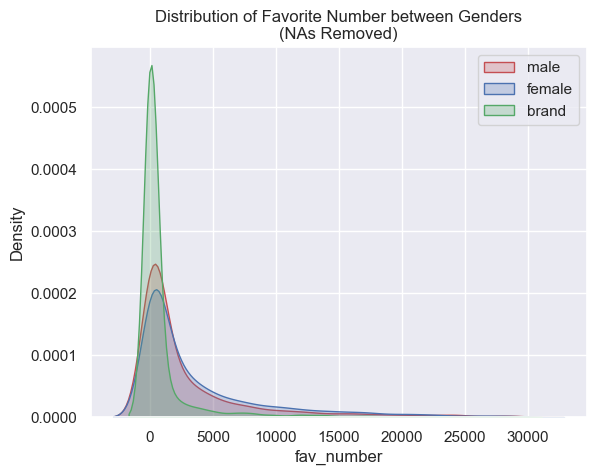

In [490]:
# Plotting before and after imputing mean for these values on a group basis
# simplest way https://www.python-graph-gallery.com/74-density-plot-of-several-variables

# before imputation but then have to remove the NA values to plot
twitter_df = pd.read_csv("/Users/brian/ALLODD PhD position assignments/tweeter_genders.tsv", sep = '\t',
                         encoding='iso-8859-1')

# remove where gender not in male, female, or brand
twitter_df = twitter_df[twitter_df.gender.isin(['male', 'female', 'brand'])]

# input blank string "" is description is blank
mask = twitter_df.description.isna()
twitter_df.loc[mask, 'description'] = ""

import seaborn as sns
sns.set(style="darkgrid")

# also need to limit to a max favorite number for better visualization
male = twitter_df.fav_number[(~twitter_df.fav_number.isna()) & 
                                        (twitter_df.gender=='male')].astype(np.int32)
male = male[male < 30000]
fig = sns.kdeplot(male, shade=True, color="r", label="male")
female = twitter_df.fav_number[(~twitter_df.fav_number.isna()) & 
                                        (twitter_df.gender=='female')].astype(np.int32)
female = female[female < 30000]
fig = sns.kdeplot(female, shade=True, color="b", label="female")
brand = twitter_df.fav_number[(~twitter_df.fav_number.isna()) & 
                                        (twitter_df.gender=='brand')].astype(np.int32)
brand = brand[brand < 30000]
fig = sns.kdeplot(brand, shade=True, color="g", label="brand")
plt.title("Distribution of Favorite Number between Genders\n(NAs Removed)")
plt.legend()
plt.show()


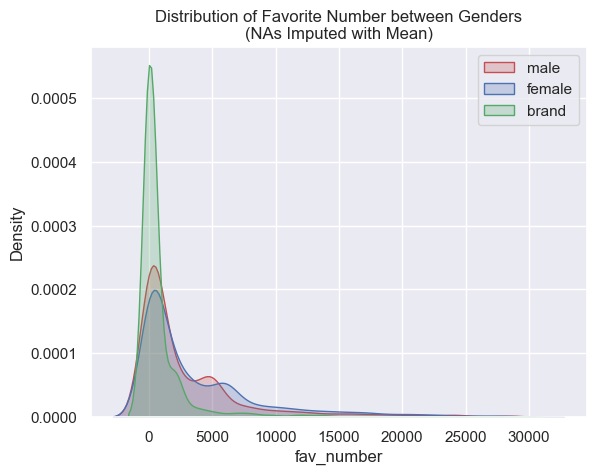

In [526]:
# After imputation
male_mean = int(np.mean(twitter_df.fav_number[(~twitter_df.fav_number.isna()) & 
                                        (twitter_df.gender=='male')].astype(np.int32)))
male_mask = (twitter_df.fav_number.isna()) & (twitter_df.gender=='male')
twitter_df.loc[male_mask, 'fav_number'] = male_mean

female_mean = int(np.mean(twitter_df.fav_number[(~twitter_df.fav_number.isna()) & 
                                        (twitter_df.gender=='female')].astype(np.int32)))
female_mask = (twitter_df.fav_number.isna()) & (twitter_df.gender=='female')
twitter_df.loc[female_mask, 'fav_number'] = female_mean

brand_mean = int(np.mean(twitter_df.fav_number[(~twitter_df.fav_number.isna()) & 
                                        (twitter_df.gender=='brand')].astype(np.int32)))
brand_mask = (twitter_df.fav_number.isna()) & (twitter_df.gender=='brand')
twitter_df.loc[brand_mask, 'fav_number'] = brand_mean

# since they are strings and not ints
twitter_df.fav_number = twitter_df.fav_number.astype(np.int32)

# also need to limit to a max favorite number for better visualization
male = twitter_df.fav_number[(~twitter_df.fav_number.isna()) & 
                                        (twitter_df.gender=='male')].astype(np.int32)
male = male[male < 30000]
fig = sns.kdeplot(male, shade=True, color="r", label="male")
female = twitter_df.fav_number[(~twitter_df.fav_number.isna()) & 
                                        (twitter_df.gender=='female')].astype(np.int32)
female = female[female < 30000]
fig = sns.kdeplot(female, shade=True, color="b", label="female")
brand = twitter_df.fav_number[(~twitter_df.fav_number.isna()) & 
                                        (twitter_df.gender=='brand')].astype(np.int32)
brand = brand[brand < 30000]
fig = sns.kdeplot(brand, shade=True, color="g", label="brand")
plt.title("Distribution of Favorite Number between Genders\n(NAs Imputed with Mean)")
plt.legend()
plt.show()

### Number of tweets

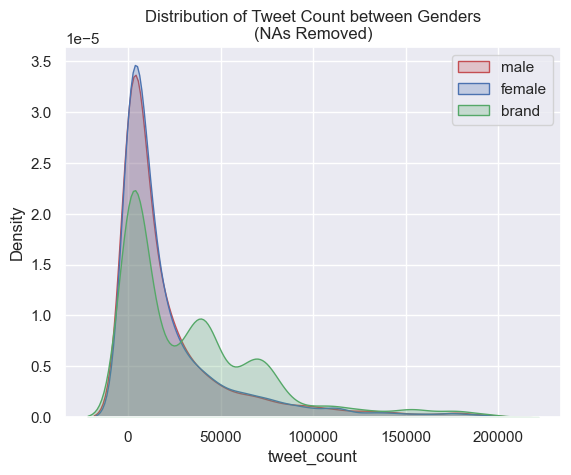

In [491]:
# also need to limit to a max favorite number for better visualization
male = twitter_df.tweet_count[(~twitter_df.tweet_count.isna()) & 
                                        (twitter_df.gender=='male')].astype(np.int32)
male = male[male < 200000]
fig = sns.kdeplot(male, shade=True, color="r", label='male')
female = twitter_df.tweet_count[(~twitter_df.tweet_count.isna()) & 
                                        (twitter_df.gender=='female')].astype(np.int32)
female = female[female < 200000]
fig = sns.kdeplot(female, shade=True, color="b", label='female')
brand = twitter_df.tweet_count[(~twitter_df.tweet_count.isna()) & 
                                        (twitter_df.gender=='brand')].astype(np.int32)
brand = brand[brand < 200000]
fig = sns.kdeplot(brand, shade=True, color="g", label='brand')
plt.title("Distribution of Tweet Count between Genders\n(NAs Removed)")
plt.legend()
plt.show()


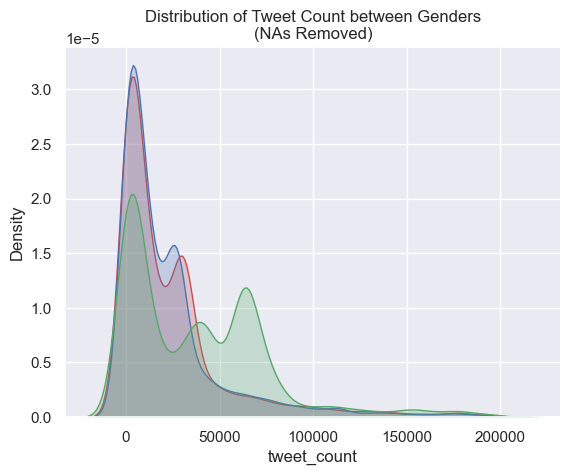

In [492]:
# After imputation
male_mean = int(np.mean(twitter_df.tweet_count[(~twitter_df.tweet_count.isna()) & 
                                        (twitter_df.gender=='male')].astype(np.int32)))
male_mask = (twitter_df.tweet_count.isna()) & (twitter_df.gender=='male')
twitter_df.loc[male_mask, 'tweet_count'] = male_mean

female_mean = int(np.mean(twitter_df.tweet_count[(~twitter_df.tweet_count.isna()) & 
                                        (twitter_df.gender=='female')].astype(np.int32)))
female_mask = (twitter_df.tweet_count.isna()) & (twitter_df.gender=='female')
twitter_df.loc[female_mask, 'tweet_count'] = female_mean

brand_mean = int(np.mean(twitter_df.tweet_count[(~twitter_df.tweet_count.isna()) & 
                                        (twitter_df.gender=='brand')].astype(np.int32)))
brand_mask = (twitter_df.tweet_count.isna()) & (twitter_df.gender=='brand')
twitter_df.loc[brand_mask, 'tweet_count'] = brand_mean

# since they are strings and not ints
twitter_df.tweet_count = twitter_df.tweet_count.astype(np.int32)

male = twitter_df.tweet_count[(~twitter_df.tweet_count.isna()) & 
                                        (twitter_df.gender=='male')].astype(np.int32)
male = male[male < 200000]
fig = sns.kdeplot(male, shade=True, color="r", label='make')
female = twitter_df.tweet_count[(~twitter_df.tweet_count.isna()) & 
                                        (twitter_df.gender=='female')].astype(np.int32)
female = female[female < 200000]
fig = sns.kdeplot(female, shade=True, color="b", label='female')
brand = twitter_df.tweet_count[(~twitter_df.tweet_count.isna()) & 
                                        (twitter_df.gender=='brand')].astype(np.int32)
brand = brand[brand < 200000]
fig = sns.kdeplot(brand, shade=True, color="g", label='brand')
plt.title("Distribution of Tweet Count between Genders\n(NAs Removed)")
plt.show()

Statistical Tests for Favorite Number after Imputation

In [532]:
import scipy.stats as ss

groups = twitter_df.groupby("gender").groups  
print(ss.f_oneway(*[twitter_df.fav_number[f] for f in groups.values()]))

# pair-wise ad-hoc (Tukey)
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=twitter_df['fav_number'],
                          groups=twitter_df['gender'],
                          alpha=0.05)
print(tukey)

F_onewayResult(statistic=176.34684730753284, pvalue=1.323858754280315e-76)
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1 group2  meandiff  p-adj   lower      upper   reject
----------------------------------------------------------
 brand female  3958.7211   0.0  3453.2513 4464.1908   True
 brand   male    2842.29   0.0  2327.2074 3357.3725   True
female   male -1116.4311   0.0 -1616.4217 -616.4405   True
----------------------------------------------------------


Statistical Tests for Tweet Counts after Imputation

In [533]:
print(ss.f_oneway(*[twitter_df.tweet_count[f] for f in groups.values()]))

# pair-wise ad-hoc (Tukey)
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=twitter_df['tweet_count'],
                          groups=twitter_df['gender'],
                          alpha=0.05)
print(tukey)

F_onewayResult(statistic=185.67284059250463, pvalue=1.406052533624185e-80)
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1 group2   meandiff  p-adj     lower       upper    reject
---------------------------------------------------------------
 brand female -36232.8901    0.0 -41015.9973 -31449.7828   True
 brand   male -32504.9199    0.0 -37378.9904 -27630.8494   True
female   male   3727.9701 0.1545  -1003.2895   8459.2297  False
---------------------------------------------------------------


Looking at the results these variables should make a difference and only help the "description" feature for the classifiers. However there was not a statistical difference in the number of tweets between males and females.